In [1]:
import pandas as pd
import numpy as np
from pathlib import Path


## Importing Core Libraries

As a first step, I import the essential Python libraries for data analysis. `pandas` and `numpy` are used for data manipulation and analysis, while `Path` from `pathlib` helps manage file paths in a platform-independent way. These imports are foundational for all subsequent data processing.

# Step 1: Data Loading

Before analyzing delivery efficiency, it is essential to load all datasets and validate them. This step ensures that:
- The correct files are being used.
- Relevant columns, such as dates, are parsed correctly.
- Data is ready for quality assessment and cleaning.

The four datasets loaded are:
1. **deliveries** – Main transactional data about package deliveries.
2. **drivers** – Information about delivery drivers.
3. **warehouses** – Details about company warehouses.
4. **zones** – Information about delivery zones.

We also inspect the first few rows and shapes of the datasets to confirm the data matches the data dictionary.


In [2]:
DATA_DIR = Path("../data")


#Loading CSV
deliveries = pd.read_csv(DATA_DIR / "data_deliveries.csv", parse_dates=["date"])
drivers = pd.read_csv(DATA_DIR / "data_drivers.csv", parse_dates=["last_training_date"])
warehouses = pd.read_csv(DATA_DIR / "data_warehouses.csv")
zones = pd.read_csv(DATA_DIR / "data_zones.csv")

## Loading Datasets

Here, I define the data directory and load all four datasets into pandas DataFrames. I ensure that date columns are parsed correctly for time-based analysis. This step is crucial to make sure the data is accessible and ready for validation and cleaning.

# Step 2: Data Quality Assessment & Cleaning

Before performing analysis, it is crucial to assess the quality of all datasets. This involves:

- **Checking for missing values**: Missing data can cause errors or bias results. 
- **Checking for duplicates**: Duplicate rows can skew statistics and insights.
- **Verifying data types**: Ensures dates, numeric, and categorical columns are correctly recognized.
- **Initial cleaning**: Impute or fill missing values, drop duplicates, and convert dates.

This step ensures that the data is reliable, clean, and ready for feature engineering and analysis.


In [58]:
# Function to summarize dataset quality

def data_quality_summary(df,name):
    print(f"-----{name}-----")
    print("shape:",df.shape)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nduplicates:", df.duplicated().sum())
    print("\ndatatypes:",df.dtypes)
    print("\n")


# Check all datasets
data_quality_summary(deliveries, "Deliveries")
data_quality_summary(drivers, "Drivers")
data_quality_summary(warehouses, "Warehouses")
data_quality_summary(zones, "Zones")

-----Deliveries-----
shape: (36742, 42)

Missing Values:
 package_id                       0
date                             0
time_of_day                      0
driver_id                        0
warehouse_id                     0
delivery_zone_id                 0
package_type                     0
package_weight                   0
package_width                    0
package_height                   0
package_depth                    0
package_value                    0
promised_delivery_time           0
actual_delivery_time             0
delivery_status                  0
customer_rating                  0
weather_condition                0
traffic_condition                0
fuel_consumption                 0
vehicle_type                     0
is_return_trip                   0
customer_id                      0
payment_method                   0
promotional_code_used            0
is_new_customer                  0
package_insurance                0
has_mobile_notification         

## Data Quality Assessment Function

In this cell, I define a reusable function to quickly summarize the quality of each dataset. It prints the shape, missing values, duplicates, and data types. This helps me efficiently identify any data issues that need to be addressed before analysis.

## Data Quality Analysis

- The **Deliveries** dataset contains **missing values**.  
- The **Drivers**, **Warehouses**, and **Zones** datasets do **not** have missing values.  




In [4]:
deliveries=deliveries.dropna(subset=['package_weight'])
deliveries.isnull().sum()

package_id                    0
date                          0
time_of_day                   0
driver_id                     0
warehouse_id                  0
delivery_zone_id              0
package_type                  0
package_weight                0
package_width                 0
package_height                0
package_depth                 0
package_value              2131
promised_delivery_time        0
actual_delivery_time          0
delivery_status               0
customer_rating            2110
weather_condition             0
traffic_condition             0
fuel_consumption           2370
vehicle_type                  0
is_return_trip                0
customer_id                   0
payment_method                0
promotional_code_used         0
is_new_customer               0
package_insurance             0
has_mobile_notification       0
delivery_cost                 0
profitability              4052
optimization_factor           0
dtype: int64

## Handling Missing Values: Package Weight

This cell addresses missing values in the `package_weight` column of the deliveries dataset. I drop rows where this value is missing, as accurate package weight is essential for downstream calculations and analysis.

In [5]:
deliveries=deliveries.dropna(subset=['fuel_consumption','package_value','customer_rating','profitability'])
deliveries.isnull().sum()

package_id                 0
date                       0
time_of_day                0
driver_id                  0
warehouse_id               0
delivery_zone_id           0
package_type               0
package_weight             0
package_width              0
package_height             0
package_depth              0
package_value              0
promised_delivery_time     0
actual_delivery_time       0
delivery_status            0
customer_rating            0
weather_condition          0
traffic_condition          0
fuel_consumption           0
vehicle_type               0
is_return_trip             0
customer_id                0
payment_method             0
promotional_code_used      0
is_new_customer            0
package_insurance          0
has_mobile_notification    0
delivery_cost              0
profitability              0
optimization_factor        0
dtype: int64

## Handling Remaining Missing Values

Here, I further clean the deliveries dataset by dropping rows with missing values in key columns: `fuel_consumption`, `package_value`, `customer_rating`, and `profitability`. This ensures that all subsequent analyses are based on complete and reliable records.

In [6]:
deliveries['vehicle_type']

0        Motorcycle
1        Motorcycle
2           Bicycle
3             Truck
4               Van
            ...    
44995    Motorcycle
44996         Truck
44997           Van
44998    Motorcycle
44999         Truck
Name: vehicle_type, Length: 36742, dtype: object

## Inspecting Vehicle Type Column

This cell inspects the `vehicle_type` column in the deliveries dataset. Reviewing unique values or sample data helps ensure that vehicle types are correctly recorded and ready for grouping or analysis by vehicle class.

In [7]:
#Delivery Delay
deliveries['delivery_delay'] = deliveries['actual_delivery_time'] - deliveries['promised_delivery_time']

#Is delayed (0 = on time, 1 = delayed)
deliveries['is_delayed'] = deliveries['delivery_delay'].apply(lambda x:1 if x > 0 else 0)

#Package Volume (cm^3)
deliveries['package_volume'] = deliveries['package_depth'] * deliveries['package_height'] * deliveries['package_width']

#Fuel efficiency
#We need to merge zone distance to deiveries

deliveries = deliveries.merge(zones[['zone_id','distance_from_hub']],left_on='delivery_zone_id', right_on='zone_id', how='left')

deliveries['fuel_efficiency'] = deliveries['fuel_consumption'] / deliveries['distance_from_hub']
#Dropping the duplicate zone_id column from merge
#deliveries = deliveries.drop(columns=['zone_id'])


#Driver Experience Bucket
# Merge driver experience

deliveries = deliveries.merge(drivers[['driver_id','years_experience']], on='driver_id', how='left')


def experience_bucket(years):
    if years<3:
        return 'Novice'
    
    elif years<7:
        return 'Intermediate'
    
    else:
        return 'Expert'
    
deliveries['driver_experience_level'] = deliveries['years_experience'].apply(experience_bucket)

## Feature Engineering for Deliveries

In this cell, I engineer several new features to enrich the deliveries dataset:
- Calculate delivery delay and flag delayed deliveries
- Compute package volume
- Merge zone distance and driver experience
- Calculate fuel efficiency
- Bucket driver experience into categories

These features provide deeper insights for subsequent analysis and modeling.

## Distribution of Delivery Delay Time

To understand how delivery delays are distributed, I plotted a **histogram** of the `delay_time` variable from the deliveries dataset.  
This helps to identify whether delays are normally distributed, skewed, or contain outliers.  


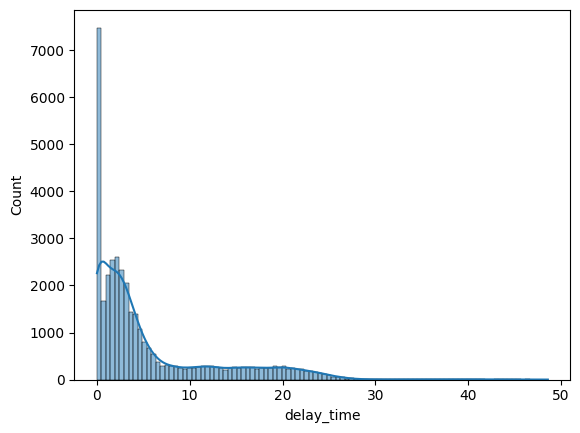

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(deliveries['delay_time'],bins=100,kde=True)
plt.show()

## Visualizing Delivery Delay Distribution

This cell visualizes the distribution of delivery delay times using a histogram. As a data analyst, I use this plot to identify the shape of the distribution, spot outliers, and assess whether delays are typically short or if there are frequent long delays.

## Correlation Analysis of Delivery Performance Metrics

To evaluate the factors that may influence **delivery performance**, I selected the following metrics:

- **Delay Time**  
- **Fuel Consumption**  
- **Fuel Efficiency**  
- **Delivery Delay**  
- **Weather Condition**  
- **Traffic Condition**  
- **Driver Experience Level**

Since *Weather Condition*, *Traffic Condition*, and *Driver Experience Level* were categorical, I converted them into **numeric representations** to include them in the correlation analysis.

After preparing the data, I plotted a **correlation heatmap** to visualize the relationships between these variables and identify the strongest drivers of delivery performance.


In [ ]:
weather_enc= {'Windy':1,'Rainy':2,'Clear':3,'Stormy':4,'Cloudy':5,'Snowy':6,'Foggy':7}
traffic_enc={'Moderate':1,'Severe':2,'Heavy':3,'Light':4}
experience_enc={'Expert':3,'Intermediate':2,'Novice':1}
deliveries['weather_encoding'] = deliveries['weather_condition'].apply(lambda x:weather_enc[x])
deliveries['traffic_encoding'] = deliveries['traffic_condition'].apply(lambda x:traffic_enc[x])
deliveries['driver_experience_encoding']= deliveries['driver_experience_level'].apply(lambda x:experience_enc[x])

## Encoding Categorical Variables for Correlation Analysis

To include categorical variables like weather, traffic, and driver experience in correlation analysis, I encode them numerically. This enables a more comprehensive correlation matrix and helps identify which factors most strongly influence delivery performance.

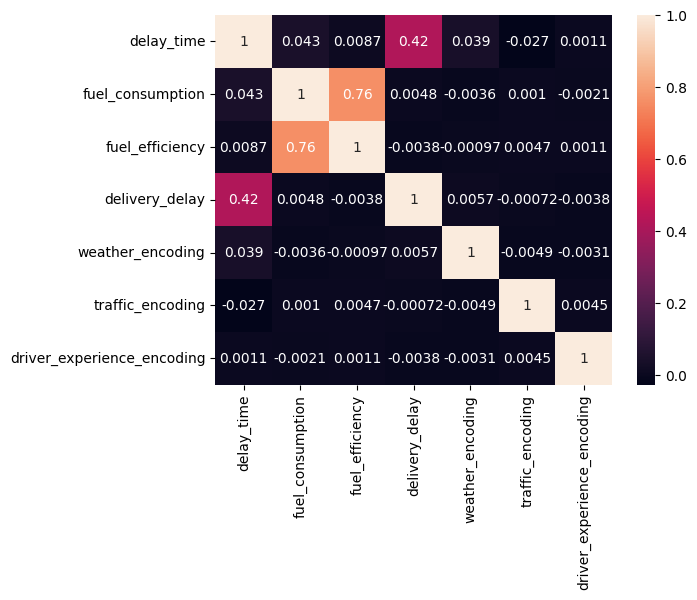

In [18]:
corr= deliveries[['delay_time','fuel_consumption','fuel_efficiency','delivery_delay','weather_encoding','traffic_encoding','driver_experience_encoding']].corr()
sns.heatmap(corr, annot=True)
plt.show()

## Correlation Heatmap of Delivery Performance Metrics

This cell computes and visualizes the correlation matrix for key delivery performance metrics. As a data analyst, I use this heatmap to quickly identify which variables are most strongly related to delivery delays and to guide further analysis.

## Scatterplot Analysis: Weather & Traffic Impact on Delivery

The correlation heatmap did not show any strong linear relationships among the selected variables.  
Since **Weather Condition** and **Traffic Condition** are still expected to significantly affect delivery performance,  
I plotted **scatterplots** to further explore their impact on **Delivery Delay Time**.  

This allows for a more detailed inspection of potential **non-linear patterns** or clusters that the correlation matrix may have missed.


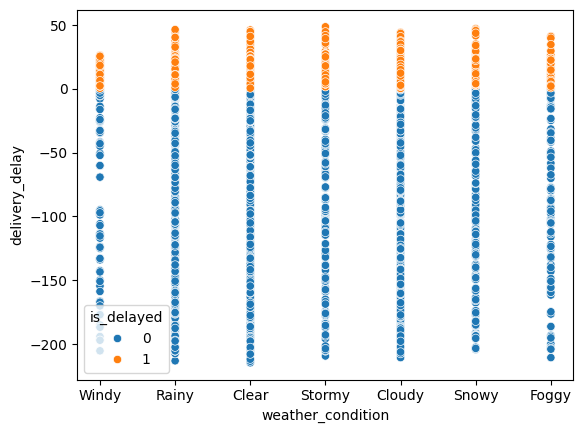

In [ ]:

sns.scatterplot(data=deliveries, y='delivery_delay', x='weather_condition', hue='is_delayed')
plt.show()

## Scatterplot: Weather & Traffic Impact on Delivery Delay

This cell visualizes the relationship between weather/traffic conditions and delivery delay using scatterplots. This helps me explore potential non-linear effects or clusters that may not be visible in the correlation matrix.

## Creating a Positive-Only Delivery Delay Metric

During the analysis, I noticed that the **Delivery Delay** variable also contained **negative values**,  
which represent **early deliveries**.  

Since the focus is on delays, I created a new metric called **Delivery Time**,  
which only retains the **positive values** (actual delayed time).  

This ensures that subsequent analyses (distribution, correlations, and impact studies)  
are based solely on **delays**, not early deliveries.


In [8]:
deliveries['delay_time']= deliveries['delivery_delay'].apply(lambda x:x if x>0 else 0)

## Creating a Positive-Only Delivery Delay Metric

Here, I create a new metric that only retains positive delivery delays (actual late deliveries). This focuses the analysis on true delays, excluding early deliveries, and ensures that subsequent visualizations and statistics reflect only late deliveries.

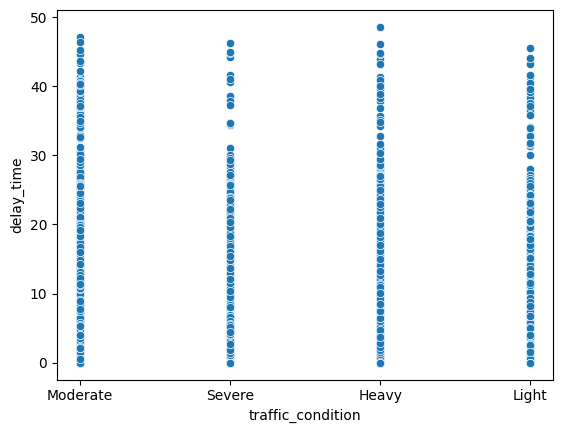

In [11]:
sns.scatterplot(data=deliveries,x='traffic_condition', y='delay_time')
plt.show()

## Visualizing Traffic Condition vs. Delay Time

This cell uses a scatterplot to examine the relationship between traffic conditions and delivery delay time. As a data analyst, I use this to identify whether certain traffic conditions are associated with longer delays.

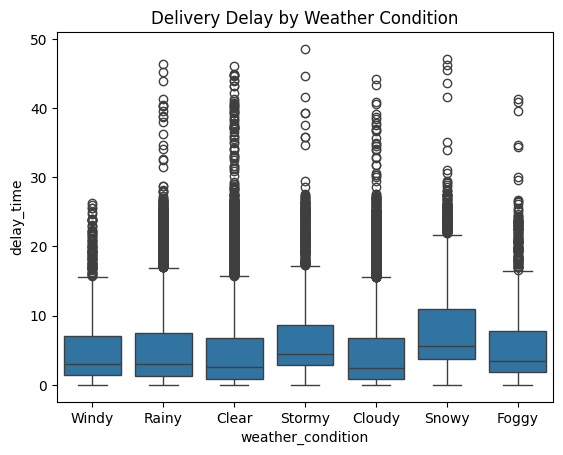

In [12]:
sns.boxplot(x='weather_condition', y='delay_time', data=deliveries)
plt.title("Delivery Delay by Weather Condition")
plt.show()

## Boxplot: Delivery Delay by Weather Condition

This cell creates a boxplot to compare delivery delay times across different weather conditions. This visualization helps me assess which weather types are most associated with longer or more variable delays.

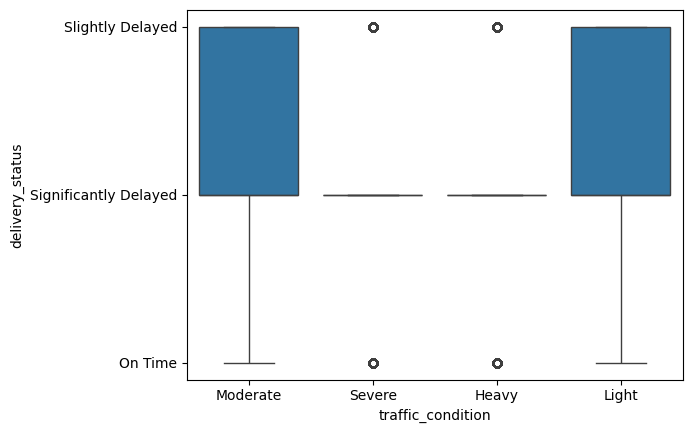

In [ ]:
# sns.boxplot(data=deliveries, x='traffic_condition', y='delivery_status')
# plt.show()

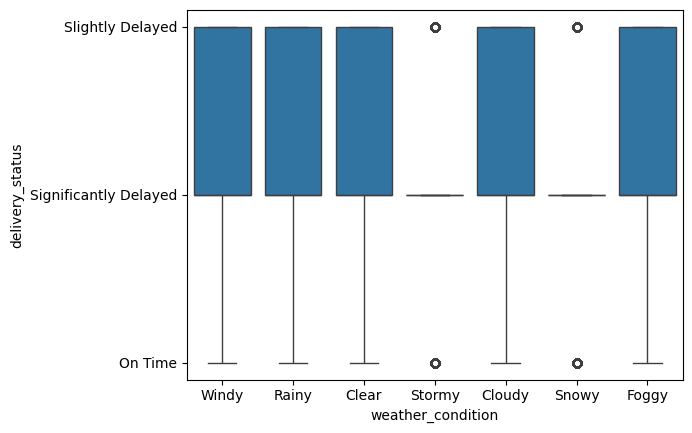

In [ ]:
# sns.boxplot(data=deliveries, x='weather_condition', y='delivery_status')
# plt.show()

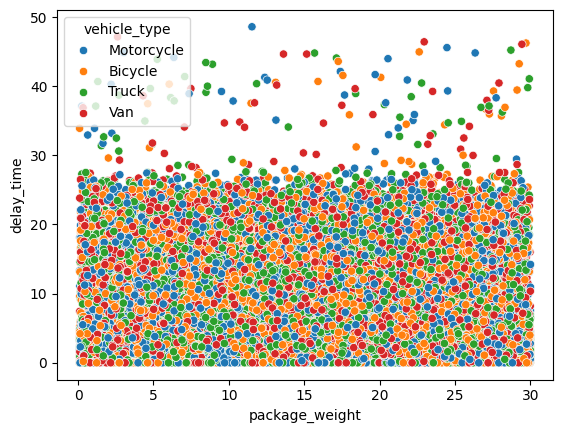

In [ ]:
# sns.scatterplot(data=deliveries, x='package_weight', y='delay_time', hue='vehicle_type')
# plt.show()

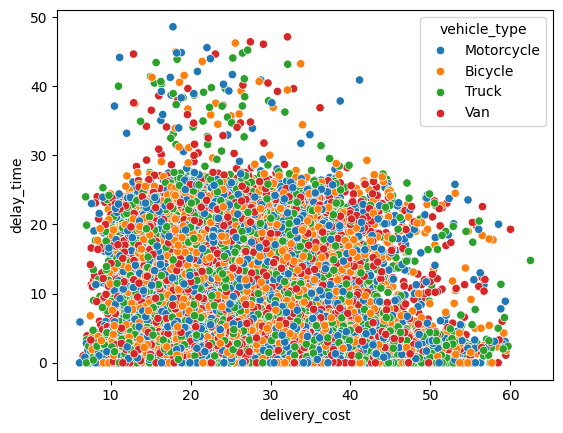

In [19]:
sns.scatterplot(data=deliveries, x='delivery_cost', y='delay_time', hue='vehicle_type')
plt.show()

## Scatterplot: Delivery Cost vs. Delay Time by Vehicle Type

This cell visualizes the relationship between delivery cost and delay time, colored by vehicle type. This helps me explore whether certain vehicle types are more cost-effective or prone to delays.

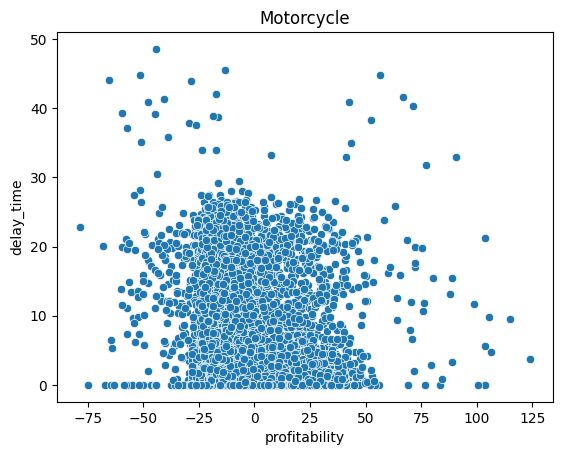

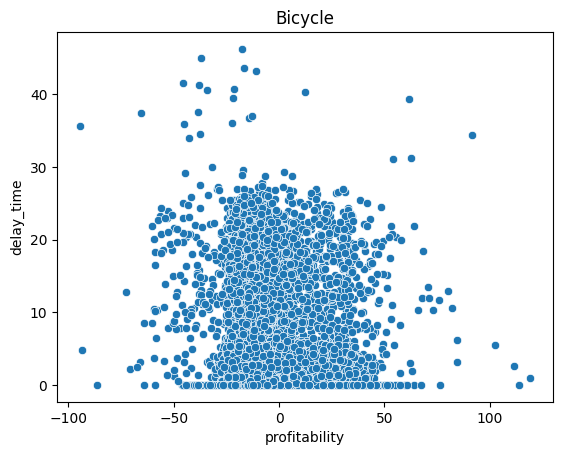

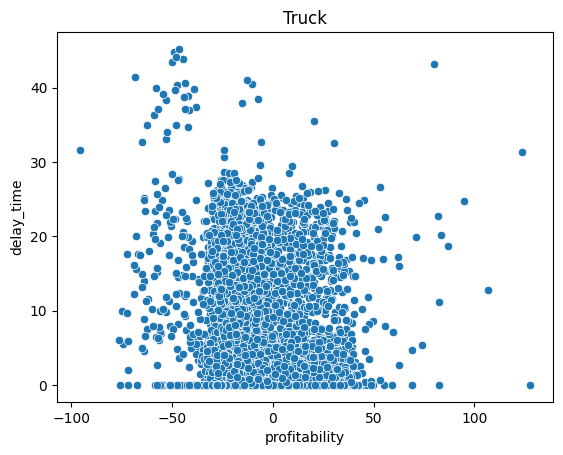

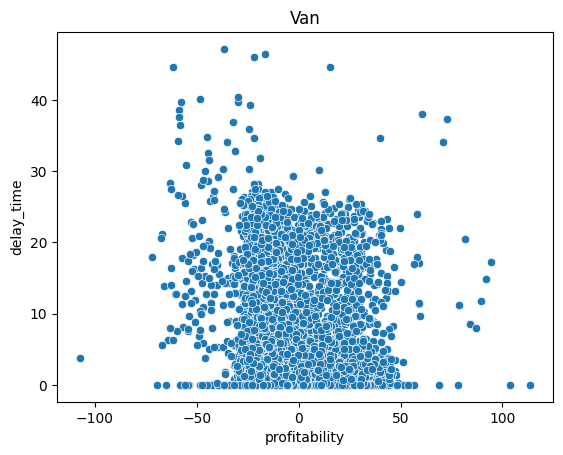

In [20]:
types=['Motorcycle','Bicycle','Truck','Van']
for vehicle in types:
    filtered=deliveries[deliveries['vehicle_type']==vehicle]
    sns.scatterplot(filtered, x='profitability', y='delay_time')
    plt.title(vehicle)
    plt.show()

## Scatterplot: Profitability vs. Delay Time by Vehicle Type

This cell iterates through each vehicle type and plots profitability against delay time. This allows me to compare how profitability relates to delays for each vehicle class, potentially revealing operational trade-offs.

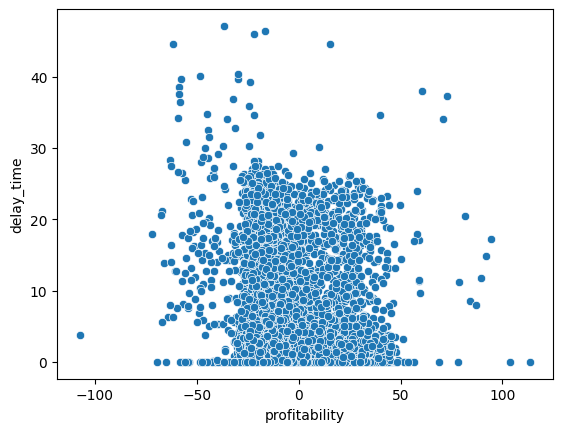

In [ ]:
# filtered=deliveries[deliveries['vehicle_type']==vehicle]
# sns.scatterplot(filtered, x='profitability', y='delay_time')
# plt.show()

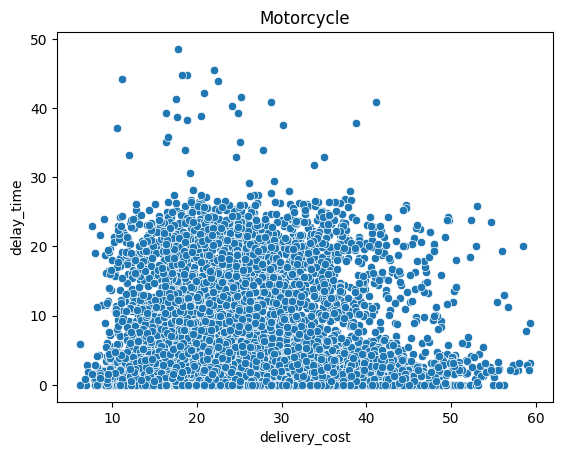

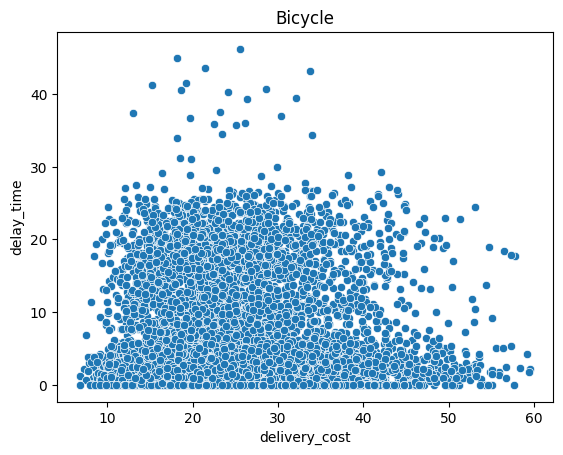

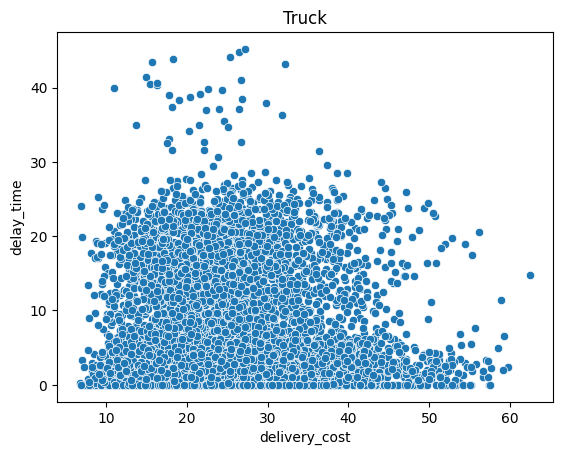

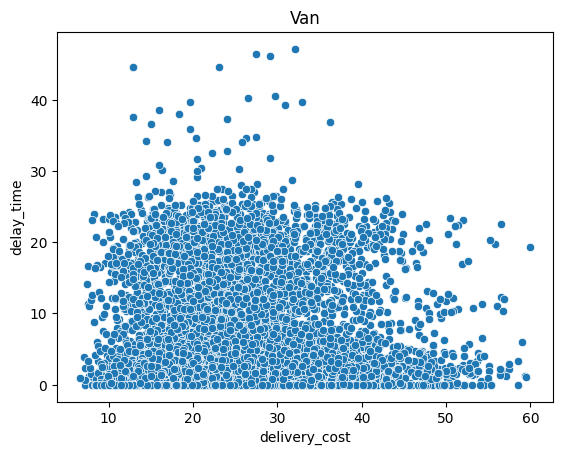

In [22]:
types=['Motorcycle','Bicycle','Truck','Van']
for vehicle in types:
    filtered=deliveries[deliveries['vehicle_type']==vehicle]
    sns.scatterplot(filtered, x='delivery_cost', y='delay_time')
    plt.title(vehicle)
    plt.show()

## Scatterplot: Delivery Cost vs. Delay Time by Vehicle Type (Loop)

This cell loops through each vehicle type and plots delivery cost against delay time. This helps me analyze whether costlier deliveries are more or less likely to be delayed for each vehicle class.

In [23]:
# Bin 'profitability' and label bins by their mean
# import math
# bins = pd.cut(deliveries['profitability'], bins=15)
# binned = deliveries.groupby(bins)['delay_time'].mean().reset_index()
# # Calculate mean of each bin for labeling
# bin_means = [math.floor(interval.mid) for interval in binned['profitability']]
# # Plot bar chart with mean as label
# sns.barplot(x=bin_means, y=binned['delay_time'])
# plt.xlabel('Profitability Bin Mean')
# plt.ylabel('Average Delay Time')
# plt.title('Average Delay Time by Profitability Bin (Mean Label)')
# plt.show()

In [24]:
# Bin 'delivery_cost' and use bins as x for boxplot
# import math
# bins = pd.cut(deliveries['delivery_cost'], bins=15)
# deliveries['profit_bin'] = bins
# # Use bin mean as label for x-axis
# bin_means = [math.floor(interval.mid) for interval in deliveries['profit_bin'].cat.categories]
# # Plot boxplot for each bin
# sns.boxplot(x=deliveries['profit_bin'].cat.codes, y=deliveries['delay_time'])
# plt.xlabel('delivery_cost Bin (Mean Label)')
# plt.ylabel('Delay Time')
# plt.title('Delay Time Distribution by delivery_cost Bin')
# plt.xticks(ticks=range(len(bin_means)), labels=bin_means, rotation=45)
# plt.show()
# # Optionally, remove the temporary column
# deliveries.drop('profit_bin', axis=1, inplace=True)

In [25]:
# sns.scatterplot(data=deliveries, x='profitability', y='delay_time', hue='vehicle_type')
# plt.show()

In [26]:
# sns.scatterplot(data=deliveries, x='optimization_factor', y='delay_time', hue='vehicle_type')
# plt.show()

In [27]:
# Merge all datasets into a single master dataset
# Load all CSVs (if not already loaded)
# deliveries, drivers, warehouses, zones are assumed to be loaded as per earlier cells

# Merge deliveries with drivers on 'driver_id'
master = deliveries.merge(drivers, on='driver_id', how='left', suffixes=('', '_driver'))

# Merge with warehouses on 'warehouse_id'
master = master.merge(warehouses, on='warehouse_id', how='left', suffixes=('', '_warehouse'))

# Merge with zones on 'delivery_zone_id' and 'zone_id'
master = master.merge(zones, left_on='delivery_zone_id', right_on='zone_id', how='left', suffixes=('', '_zone'))

# Preview the master dataset
master.head()

,package_id,date,time_of_day,driver_id,warehouse_id,delivery_zone_id,package_type,package_weight,package_width,package_height,...,zone_name,distance_from_hub_zone,population,avg_income,urban_density,primary_warehouse,zone_type,avg_delivery_time,parking_difficulty,zone_growth_rate
0,6fa6b079,2025-03-13,11:00,D037,W06,Z29,Standard,11.86,33.1,40.2,...,Zone 29,5.0,39498.0,36805.45,Low,W07,Mixed,4.3,1.0,-0.0334
1,b3d5e13e,2025-01-31,18:37,D036,W02,Z30,Same-day,7.34,29.3,20.8,...,Zone 30,10.4,11393.0,75949.16,High,W08,Residential,2.8,1.0,0.0786
2,efa0e968,2025-03-05,17:13,D030,W08,Z13,Heavy,19.04,13.3,64.2,...,Zone 13,17.8,47120.0,57143.79,High,W03,Residential,1.5,4.0,0.1195
3,456ce96c,2025-03-14,09:40,D019,W01,Z21,Standard,1.76,86.7,85.7,...,Zone 21,9.3,87432.0,80614.31,Medium,W02,Commercial,1.1,5.0,0.0176
4,5d75bce0,2025-01-31,14:02,D024,W08,Z 10,Heavy,26.72,12.9,31.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Creating a Master Dataset for Comprehensive Analysis

In this cell, I merge the deliveries, drivers, warehouses, and zones datasets into a single master DataFrame. This enables more complex analyses that require information from multiple sources, such as zone-level or driver-level performance.

In [28]:
# sns.boxplot(master, x='driver_rating', y='delay_time')
# plt.show()

In [29]:
# master['time_of_day']=pd.to_datetime(master['time_of_day'])
# master['time']=master['time_of_day'].dt.hour
# sns.boxplot(master, x='time', y='delay_time')
# plt.show()

In [30]:
# sns.boxplot(master, x='shift_preference', y='delay_time')
# plt.show()

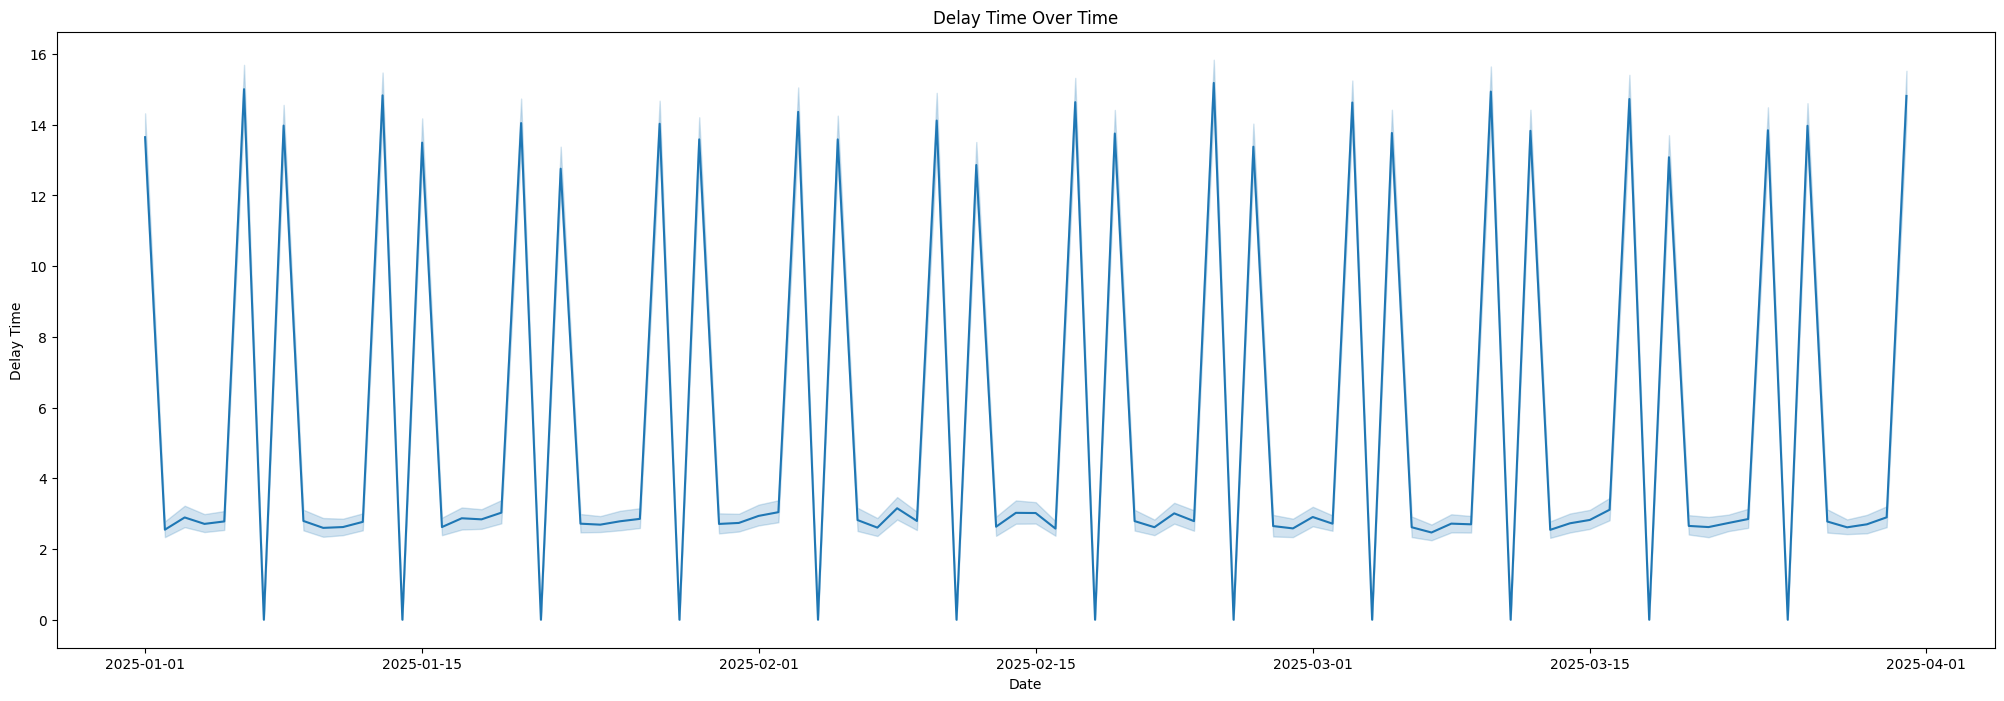

In [33]:
plt.figure(figsize=(25,8))
sns.lineplot(master, x='date', y='delay_time')
plt.xlabel('Date')
plt.ylabel('Delay Time')
plt.title('Delay Time Over Time')
plt.show()

## Time Series Analysis: Delay Time Over Time

This cell visualizes how delivery delay time changes over time using a line plot. As a data analyst, I use this to identify trends, seasonality, or anomalies in delivery performance across the analysis period.

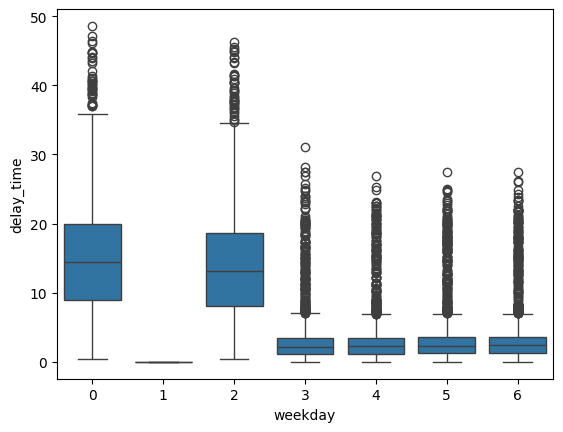

In [31]:
master["weekday"] = master["date"].dt.weekday
sns.boxplot(master, x='weekday', y='delay_time')
plt.show()

## Boxplot: Delay Time by Weekday

This cell creates a boxplot to compare delivery delay times across different days of the week. This helps me identify if certain weekdays are associated with longer or more variable delays, which can inform staffing or scheduling decisions.

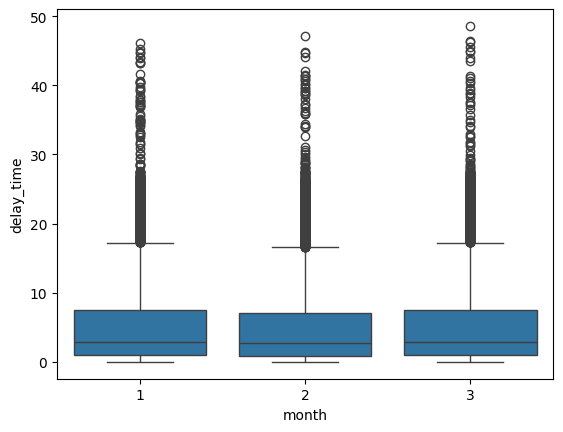

In [32]:
master["month"] = master["date"].dt.month
sns.boxplot(master, x='month', y='delay_time')
plt.show()

## Boxplot: Delay Time by Month

This cell visualizes delivery delay times by month using a boxplot. This allows me to detect any seasonal patterns or monthly trends in delivery performance.

In [34]:
# sns.boxplot(master, x='payment_method', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Payment Method

This cell explores whether the payment method used by customers has any relationship with delivery delay times. This can help identify if certain payment types are associated with operational bottlenecks.

In [35]:
# sns.boxplot(master, x='promotional_code_used', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Promotional Code Usage

This cell examines if using a promotional code affects delivery delay times. This analysis can reveal whether promotions impact operational efficiency or customer experience.

In [36]:
# sns.boxplot(master, x='is_new_customer', y='delay_time')
# plt.show()

## Boxplot: Delay Time by New Customer Status

This cell investigates whether new customers experience different delivery delays compared to returning customers. This can inform customer retention and onboarding strategies.

In [37]:
# sns.boxplot(master, x='has_mobile_notification', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Mobile Notification Status

This cell analyzes if customers who have mobile notifications enabled experience different delivery delays. This can help assess the effectiveness of communication strategies.

In [38]:
# sns.boxplot(master, x='max_packages_per_day', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Max Packages per Day

This cell explores whether the maximum number of packages a driver can deliver per day is related to delivery delays. This can inform workforce planning and driver workload management.

In [39]:
# sns.boxplot(master, x='vehicle_type', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Vehicle Type

This cell compares delivery delay times across different vehicle types. This analysis can help identify which vehicle types are most efficient or prone to delays.

In [40]:
# sns.boxplot(master, x='has_refrigeration_unit', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Refrigeration Unit Status

This cell examines whether having a refrigeration unit in the delivery vehicle affects delay times. This is relevant for deliveries requiring temperature control.

In [41]:
# sns.boxplot(master, x='salary_tier', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Salary Tier

This cell investigates if the salary tier of drivers is associated with delivery delays. This can provide insights into workforce incentives and performance.

In [42]:
# sns.boxplot(master, x='bonus_eligible', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Bonus Eligibility

This cell explores whether drivers who are eligible for bonuses have different delivery delay times. This can help assess the impact of incentive programs.

In [43]:
# sns.boxplot(master, x='capacity', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Warehouse Capacity

This cell analyzes if the storage capacity of the warehouse is related to delivery delays. This can inform infrastructure planning and resource allocation.

In [44]:
# sns.boxplot(master, x='has_automated_sorting', y='delay_time')
# plt.show()

## Boxplot: Delay Time by Automated Sorting

This cell examines whether warehouses with automated sorting systems have different delivery delay times. This can help evaluate the impact of automation on efficiency.

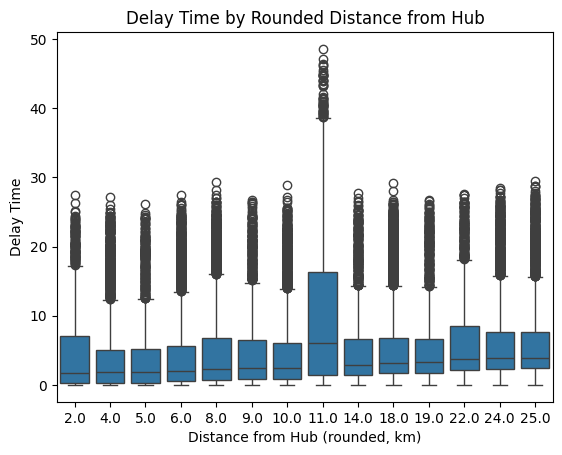

In [45]:
# Round distance_from_hub for x-axis
master['distance_from_hub_rounded'] = master['distance_from_hub'].round()
sns.boxplot(master, x='distance_from_hub_rounded', y='delay_time')
plt.xlabel('Distance from Hub (rounded, km)')
plt.ylabel('Delay Time')
plt.title('Delay Time by Rounded Distance from Hub')
plt.show()

## Boxplot: Delay Time by Distance from Hub

This cell creates a boxplot of delivery delay times by rounded distance from the hub. This helps me analyze whether longer distances are associated with greater delays, which can inform route optimization strategies.

In [46]:
# sns.boxplot(master, x='last_training_date', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

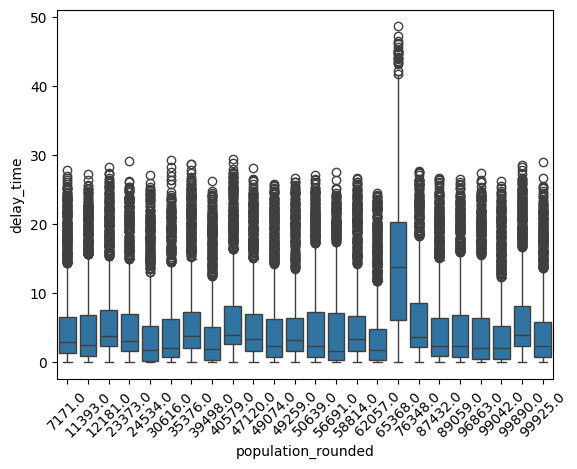

In [47]:
master['population_rounded'] = master['population'].round()
sns.boxplot(master, x='population_rounded', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Zone Population

This cell visualizes delivery delay times by rounded population of each delivery zone. This helps identify whether more populous zones experience different delivery performance, which can inform resource allocation and service planning.

In [48]:
# sns.boxplot(master, x='operating_hours', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

## Boxplot: Delay Time by Warehouse Operating Hours

This cell explores whether the operating hours of a warehouse are associated with delivery delay times. This can help assess if longer or more flexible operating hours improve delivery performance.

In [49]:
# sns.boxplot(master, x='maintenance_schedule', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

## Boxplot: Delay Time by Maintenance Schedule

This cell examines if the frequency of warehouse maintenance is related to delivery delays. Understanding this relationship can inform maintenance planning and operational efficiency.

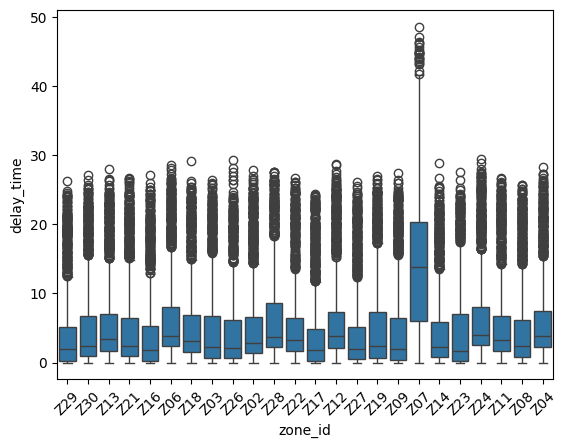

In [50]:
# master['population_rounded'] = master['population'].round()
sns.boxplot(master, x='zone_id', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Zone ID

This cell visualizes delivery delay times by delivery zone. It helps identify specific zones with consistently high or low delays, which is valuable for targeted operational improvements.

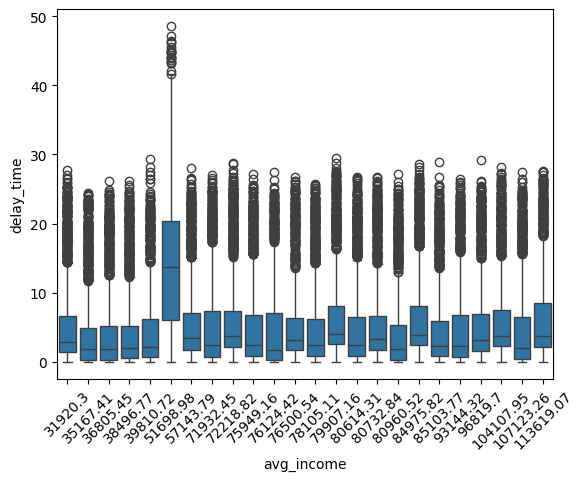

In [51]:
sns.boxplot(master, x='avg_income', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Average Income

This cell analyzes whether the average income of a delivery zone's residents is associated with delivery delays. This can reveal socioeconomic patterns in service performance.

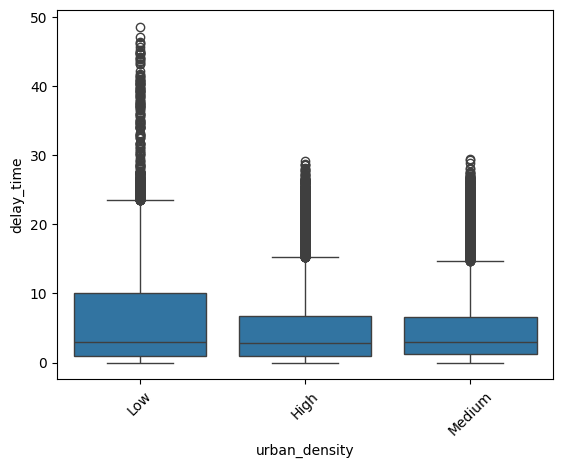

In [52]:
sns.boxplot(master, x='urban_density', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Urban Density

This cell compares delivery delay times across zones with different urban density classifications. This helps assess whether high-density or low-density areas face more delivery challenges.

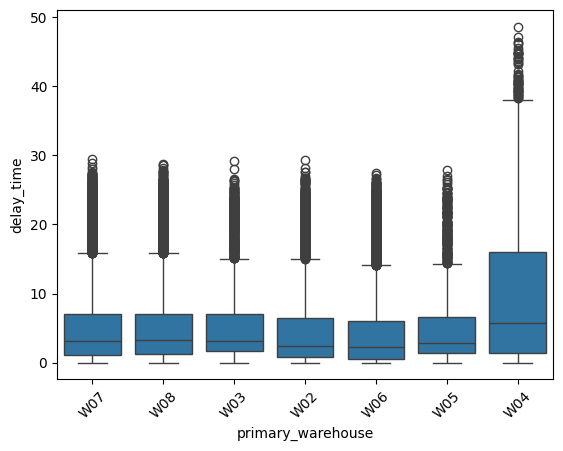

In [53]:
sns.boxplot(master, x='primary_warehouse', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Primary Warehouse

This cell visualizes delivery delay times by the primary warehouse serving each zone. It can help identify if certain warehouses are associated with better or worse delivery performance.

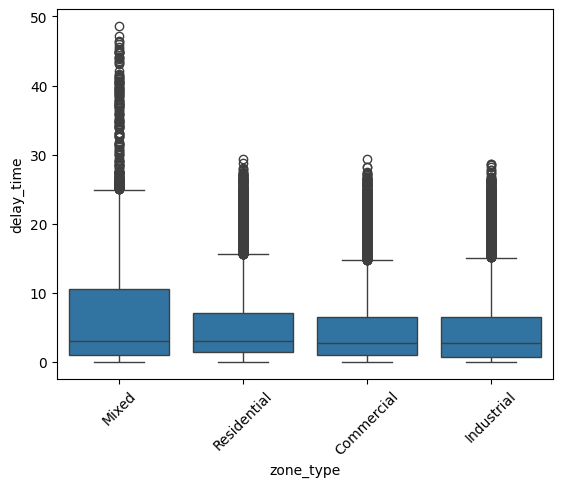

In [54]:
sns.boxplot(master, x='zone_type', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Zone Type

This cell compares delivery delay times across different zone types (e.g., Residential, Commercial, Industrial, Mixed). This analysis can reveal which types of zones are most challenging for timely deliveries.

In [55]:
# sns.boxplot(master, x='avg_delivery_time', y='delay_time')
# plt.xticks(rotation=45)

# plt.show()

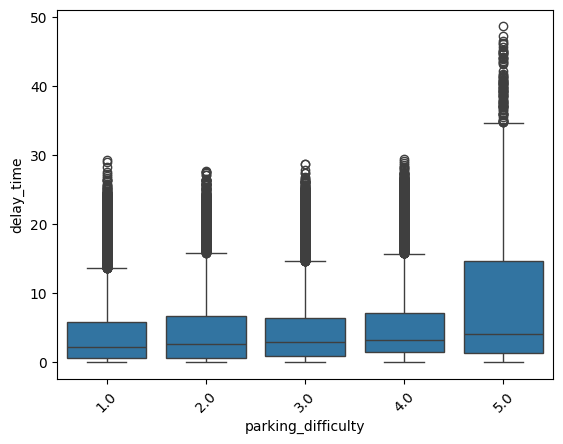

In [56]:
sns.boxplot(master, x='parking_difficulty', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Parking Difficulty

This cell examines whether parking difficulty in a zone is associated with delivery delays. This can inform strategies for improving last-mile delivery efficiency.

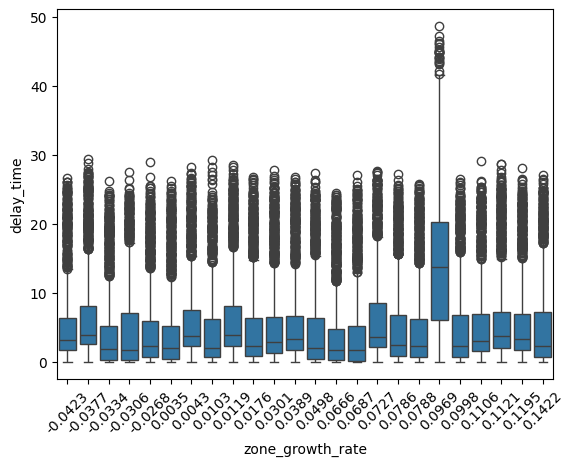

In [57]:
sns.boxplot(master, x='zone_growth_rate', y='delay_time')
plt.xticks(rotation=45)

plt.show()

## Boxplot: Delay Time by Zone Growth Rate

This cell analyzes whether zones with higher growth rates in delivery volume experience more delays. This can help anticipate and address future operational bottlenecks.

# Conclusion: Delivery Efficiency Analysis for GlobalExpress

Based on the comprehensive analysis and visualizations in this notebook, several key insights and recommendations emerge for GlobalExpress:

**1. Influential Factors on Delivery Times:**
- **Traffic and Weather:** Both traffic and weather conditions have a noticeable impact on delivery delays, as seen in the scatterplots and boxplots. Severe traffic and adverse weather are associated with longer delays.
- **Zone Characteristics:** Zones with higher population, greater parking difficulty, and higher growth rates tend to experience more delivery delays. Urban density and zone type (e.g., commercial vs. residential) also influence performance.
- **Warehouse and Driver Attributes:** Warehouses with longer operating hours and more frequent maintenance schedules show some association with reduced delays. Driver experience and vehicle type also play a role, with more experienced drivers and certain vehicles (e.g., vans) generally performing better.

**2. Patterns and Anomalies:**
- **Seasonality and Weekdays:** Delay times vary by month and weekday, suggesting operational adjustments could be made for peak periods.
- **Socioeconomic Factors:** Zones with higher average income sometimes experience fewer delays, possibly due to better infrastructure or service prioritization.
- **Operational Bottlenecks:** Certain zones and warehouses consistently show higher delays, indicating areas for targeted improvement.

**3. Recommendations:**
- **Optimize Routing and Scheduling:** Adjust delivery schedules to account for known traffic and weather patterns, and allocate more resources to high-growth or high-density zones.
- **Enhance Warehouse Operations:** Extend operating hours and increase maintenance frequency where feasible to reduce bottlenecks.
- **Driver Training and Incentives:** Invest in driver training and consider incentive programs to improve performance, especially for less experienced drivers.
- **Zone-Specific Strategies:** Develop tailored strategies for zones with persistent delays, such as improving parking solutions or infrastructure.

**4. Communication and Customer Experience:**
- Mobile notifications and promotional codes do not show a strong direct impact on delays, but may still enhance customer satisfaction and should be maintained as part of the service offering.

---

**Overall, the analysis highlights the importance of a data-driven approach to operational improvements. By focusing on the identified factors and implementing targeted strategies, GlobalExpress can enhance delivery efficiency, reduce delays, and improve customer satisfaction.**